We aim to predict travel time minutes per trip id using features like route id , hour of the dat and route type 

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [34]:
#libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import os
print(os.getcwd())

C:\Users\S P E C T R E\Desktop\Personal Projects\umpire


In [3]:
base_path = r"C:\Users\S P E C T R E\Desktop\Personal Projects\umpire\gtfs-accra-ghana-2016"

In [4]:
stop_times = pd.read_csv(f"{base_path}\\stop_times.csv")
trips = pd.read_csv(f"{base_path}\\trips.csv")
routes = pd.read_csv(f"{base_path}\\routes.csv")
calendar = pd.read_csv(f"{base_path}\\calendar.csv")
shapes = pd.read_csv(f"{base_path}\\shapes.csv")
stops = pd.read_csv(f"{base_path}\\stops.csv")
fare_rules = pd.read_csv(f"{base_path}\\fare_rules.csv")
fare_attributes = pd.read_csv(f"{base_path}\\fare_attributes.csv")
agency = pd.read_csv(f"{base_path}\\agency.csv")

In [5]:
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,651001,5.567347,-0.216433,113
1,1001,5.607725,-0.246924,2
2,1001,5.607516,-0.247544,3
3,1001,5.607274,-0.248139,4
4,1001,5.606926,-0.248921,5
...,...,...,...,...
86372,651001,5.566694,-0.214837,109
86373,651001,5.566445,-0.214769,110
86374,651001,5.566071,-0.216071,111
86375,651001,5.566811,-0.216261,112


In [6]:
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,service,1,1,1,1,1,1,1,20150520,20170531


### Calculating travel time per trip

In [7]:
#convert times to timedelta
stop_times["arrival_time"] = pd.to_timedelta(stop_times["arrival_time"], errors = "coerce")
stop_times["departure_time"] = pd.to_timedelta(stop_times["departure_time"], errors = "coerce")

#trip start and end times
trip_durations = (
    stop_times.groupby('trip_id')
    .agg(start_time=('departure_time', 'min'), end_time=('arrival_time', 'max'))
    .reset_index()
)

# Calculate travel time in minutes
trip_durations['travel_time_minutes'] = (trip_durations['end_time'] - trip_durations['start_time']).dt.total_seconds() / 60
trip_durations.head()

,trip_id,start_time,end_time,travel_time_minutes
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000


### Feature Engineering - Route info + hour of day

In [8]:
print(trips.columns.tolist())

['route_id', 'service_id', 'trip_id', 'shape_id']


In [9]:
# Merge trip_durations with trips.csv
trip_durations = trip_durations.merge(trips[['trip_id', 'route_id', 'service_id']], on='trip_id', how='left')

# Merge with routes.csv to get route_type
trip_durations = trip_durations.merge(routes[['route_id', 'route_type']], on='route_id', how='left')

# Get the first stop (where trip starts)
first_stops = stop_times.groupby('trip_id').first().reset_index()

# Extract hour from departure time
first_stops['hour_of_day'] = first_stops['departure_time'].dt.components['hours']  #this feature is to represent what time of day a trip starts. helps with rush hour  

# Merge hour_of_day into the trip_durations DataFrame
df = trip_durations.merge(first_stops[['trip_id', 'hour_of_day']], on='trip_id', how='left')
df.head()

,trip_id,start_time,end_time,travel_time_minutes,route_id,service_id,route_type,hour_of_day
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667,002B,service,3,13
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667,003A,service,3,13
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000,003B,service,3,15
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000,004A,service,3,13


### calculating total distance in km for each shape id

In [10]:
# Sort points in order
shapes_sorted = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

# Function to compute distance along a shape
def compute_shape_distance(df):
    total_distance = 0
    for i in range(1, len(df)):
        point1 = (df.iloc[i - 1]['shape_pt_lat'], df.iloc[i - 1]['shape_pt_lon'])
        point2 = (df.iloc[i]['shape_pt_lat'], df.iloc[i]['shape_pt_lon'])
        total_distance += geodesic(point1, point2).kilometers
    return total_distance

# Group by shape_id and calculate distance
shape_distances = shapes_sorted.groupby('shape_id').apply(compute_shape_distance).reset_index()
shape_distances.columns = ['shape_id', 'trip_distance_km']

C:\Users\S P E C T R E\AppData\Local\Temp\ipykernel_20604\3233167637.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_distances = shapes_sorted.groupby('shape_id').apply(compute_shape_distance).reset_index()


In [11]:
#merging with the total distance with trip data 
# Merge shape_id into your main df
df = df.merge(trips[['trip_id', 'shape_id']], on='trip_id', how='left')

# Merge trip_distance_km from shape_distances
df = df.merge(shape_distances, on='shape_id', how='left')

In [12]:
df.head()

,trip_id,start_time,end_time,travel_time_minutes,route_id,service_id,route_type,hour_of_day,shape_id,trip_distance_km
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667,002B,service,3,13,278001,4.676327
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667,003A,service,3,13,380001,8.391710
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000,003B,service,3,15,381001,7.823915
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000,004A,service,3,13,554001,28.015865


In [14]:
#adding day of the week/weekend
# Melt it to long format to create (service_id, day_name, is_active)
calendar_long = calendar.melt(
    id_vars=['service_id'],
    value_vars=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'],
    var_name='day_name',
    value_name='is_active'
)

# Filter only active days
calendar_long = calendar_long[calendar_long['is_active'] == 1]

# Merge calendar info to trip_durations using service_id
df = df.merge(calendar_long, on='service_id', how='left')

# Optional: create is_weekend / is_weekday
df['is_weekend'] = df['day_name'].isin(['saturday', 'sunday']).astype(int)
df['is_weekday'] = 1 - df['is_weekend']
#the model will now havr context like "this route runs on weekends which can influence travel time and demand due to traffic patterns

In [15]:
df

,trip_id,start_time,end_time,travel_time_minutes,route_id,service_id,route_type,hour_of_day,shape_id,trip_distance_km,day_name,is_active,is_weekend,is_weekday
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838,monday,1,0,1
1,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838,tuesday,1,0,1
2,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838,wednesday,1,0,1
3,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838,thursday,1,0,1
4,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838,friday,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,999B_1,0 days 15:13:01,0 days 15:49:40,36.650000,999B,service,3,15,517001,7.324481,wednesday,1,0,1
4553,999B_1,0 days 15:13:01,0 days 15:49:40,36.650000,999B,service,3,15,517001,7.324481,thursday,1,0,1
4554,999B_1,0 days 15:13:01,0 days 15:49:40,36.650000,999B,service,3,15,517001,7.324481,friday,1,0,1
4555,999B_1,0 days 15:13:01,0 days 15:49:40,36.650000,999B,service,3,15,517001,7.324481,saturday,1,1,0


In [16]:
df.shape  # returns (num_rows, num_columns)

(4557, 14)

In [17]:
df.isnull().sum()

trip_id                0
start_time             0
end_time               0
travel_time_minutes    0
route_id               0
service_id             0
route_type             0
hour_of_day            0
shape_id               0
trip_distance_km       0
day_name               0
is_active              0
is_weekend             0
is_weekday             0
dtype: int64

In [18]:
#input features and target
# Define input features and target
features = ['route_type', 'hour_of_day', 'trip_distance_km', 'is_weekend']  #because the features known before the trip starts. route type ; diff vehicles = diff speeds and hour of the day tells us morning rush , low traffic etc 
X = df[features]
y = df['travel_time_minutes']

In [19]:
X = pd.get_dummies(X, columns=['route_type'], drop_first=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#baseline model 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Linear Regression MAE:", round(mean_absolute_error(y_test, lr_preds), 2), "minutes")

Linear Regression MAE: 14.8 minutes


In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred)
print("Random Forest MAE with distance:", round(mean_absolute_error(y_test, y_pred), 2), "minutes")

Random Forest MAE with distance: 0.43 minutes


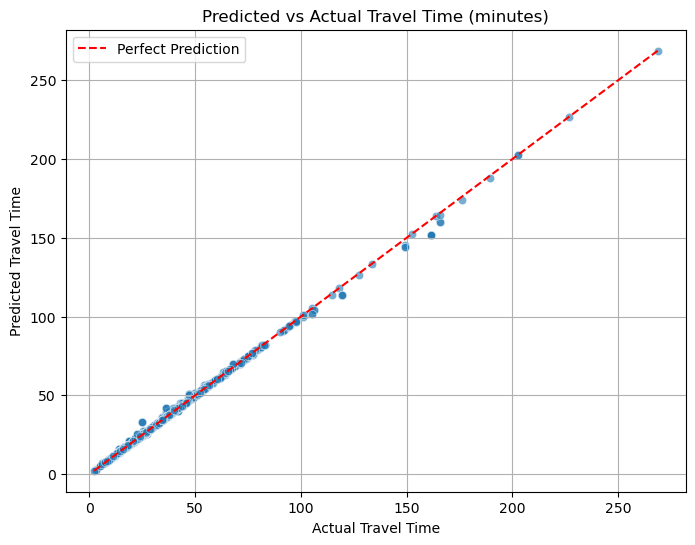

In [29]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.title('Predicted vs Actual Travel Time (minutes)')
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
##indicator of a well performing model

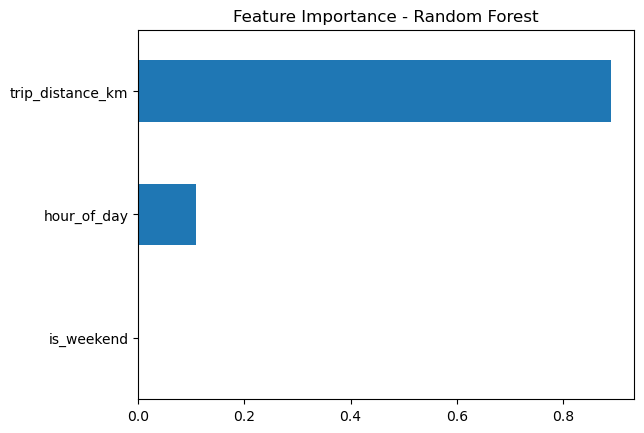

In [32]:
#checking feature importance 
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance - Random Forest')
plt.show()

In [35]:
#trying XGBoost
# Train the model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

# Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost MAE: {xgb_mae:.2f} minutes")

XGBoost MAE: 3.81 minutes
